# **Initial Setup**

In [1]:
import torch
import os
import gc

def check_gpu():
    print(f"CUDA Available: {torch.cuda.is_available()}")
    
    if torch.cuda.is_available():
        print(f"Number of GPUs: {torch.cuda.device_count()}")
        print(f"GPU Device Name: {torch.cuda.get_device_name(0)}")
        print(f"Current GPU Device: {torch.cuda.current_device()}")
    else:
        print("No GPU detected. Running on CPU.")

check_gpu()

# CUDA configs
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.cuda.empty_cache()
gc.collect()

CUDA Available: True
Number of GPUs: 1
GPU Device Name: Tesla V100-SXM2-32GB
Current GPU Device: 0


260

In [2]:
!pip install opencv-python
!pip install numpy
!pip install pandas
!pip install torch torchvision
!pip install transformers
!pip install tqdm
!pip install matplotlib
!pip install albumentations
!pip install ipywidgets
!pip install jupyterlab-widgets

from tqdm.auto import tqdm
from tqdm import TqdmWarning
import warnings
warnings.filterwarnings('ignore', category=TqdmWarning)

Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo20

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import confusion_matrix

# Define paths
BASE_DIR = "/home/thatkar/projects/def-saadi/thatkar"
ROOT_DIR = os.path.join(BASE_DIR, "CamVid")
TRAIN_DIR = os.path.join(ROOT_DIR, "train")
TRAIN_LABELS_DIR = os.path.join(ROOT_DIR, "train_labels")
VAL_DIR = os.path.join(ROOT_DIR, "val")
VAL_LABELS_DIR = os.path.join(ROOT_DIR, "val_labels")
TEST_DIR = os.path.join(ROOT_DIR, "test")
TEST_LABELS_DIR = os.path.join(ROOT_DIR, "test_labels")
CLASS_DICT_PATH = os.path.join(ROOT_DIR, "class_dict.csv")
CHECKPOINT_DIR = os.path.join(ROOT_DIR, "checkpoints")
VISUALIZATION_DIR = os.path.join(ROOT_DIR, "visualizations")

# Create necessary directories
for directory in [CHECKPOINT_DIR, VISUALIZATION_DIR]:
    os.makedirs(directory, exist_ok=True)

# Training Hyperparameters
IMAGE_HEIGHT = 960  # Original CamVid resolution
IMAGE_WIDTH = 768
BATCH_SIZE = 1
ACCUMULATION_STEPS = 16
NUM_EPOCHS = 45
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 0.01
GRAD_CLIP_VALUE = 1.0

2025-02-12 11:15:03.659076: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-12 11:15:11.124224: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-12 11:15:11.359625: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-12 11:15:11.459294: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-12 11:15:13.210328: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# Define data augmentation pipelines
train_transforms = A.Compose([
    A.RandomResizedCrop(
        size=(IMAGE_HEIGHT, IMAGE_WIDTH),
        scale=(0.8, 1.0),
        ratio=(0.75, 1.33),
        p=1.0,
        interpolation=cv2.INTER_LINEAR
    ),
    A.OneOf([
        A.RandomBrightnessContrast(
            brightness_limit=0.2,
            contrast_limit=0.2,
            p=0.5
        ),
        A.RandomGamma(gamma_limit=(80, 120), p=0.5),
        A.RandomShadow(
            shadow_roi=(0, 0.5, 1, 1),
            p=0.5
        ),
    ], p=0.7),
    A.OneOf([
        A.Affine(
            scale=(0.9, 1.1),
            translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)},
            rotate=(-15, 15),
            border_mode=cv2.BORDER_CONSTANT
        ),
        A.ElasticTransform(
            alpha=120,
            sigma=6,
            p=0.5
        ),
    ], p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH, interpolation=cv2.INTER_LINEAR),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [4]:
class CamVidDataset(Dataset):
    """
    Dataset class for CamVid with enhanced validation and error handling
    """
    def __init__(self, image_dir, label_dir, feature_extractor, transforms=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.feature_extractor = feature_extractor
        self.ignore_index = 255

        # Load class definitions and create mappings
        self.class_df = pd.read_csv(CLASS_DICT_PATH)
        self.num_classes = len(self.class_df)
        
        # Create color mapping dictionary (BGR format for OpenCV)
        self.color_mapping = {}
        for idx, row in self.class_df.iterrows():
            bgr_color = (int(row['b']), int(row['g']), int(row['r']))
            self.color_mapping[bgr_color] = idx

        # Validate and filter images
        all_images = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
        self.images = []
        
        print(f"Validating images in {image_dir}...")
        for img_name in all_images:
            label_name = img_name.replace('.png', '_L.png')
            img_path = os.path.join(image_dir, img_name)
            label_path = os.path.join(label_dir, label_name)
            
            if os.path.exists(label_path):
                img_test = cv2.imread(img_path)
                label_test = cv2.imread(label_path)
                if img_test is not None and label_test is not None:
                    self.images.append(img_name)
                else:
                    print(f"Warning: Failed to load {img_name} or its label")
            else:
                print(f"Warning: Missing label for {img_name}")

        print(f"Found {len(self.images)} valid image-label pairs")
        
        if len(self.images) == 0:
            raise RuntimeError(f"No valid image-label pairs found in {image_dir}")

    def __getitem__(self, idx):
        """
        Load and process a single image-label pair with proper error handling
        """
        try:
            # Load and process input image
            image_path = os.path.join(self.image_dir, self.images[idx])
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Failed to load image: {image_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Load and process label image
            label_path = os.path.join(self.label_dir, self.images[idx].replace('.png', '_L.png'))
            label = cv2.imread(label_path)
            if label is None:
                raise ValueError(f"Failed to load label: {label_path}")

            # Create label mask using vectorized operations
            h, w = label.shape[:2]
            pixels = label.reshape(-1, 3)
            pixel_classes = np.full(len(pixels), self.ignore_index, dtype=np.int64)
            
            for bgr_color, class_idx in self.color_mapping.items():
                matches = np.all(pixels == bgr_color, axis=1)
                pixel_classes[matches] = class_idx

            label_mask = pixel_classes.reshape(h, w)

            # Apply transforms with error handling
            if self.transforms:
                try:
                    transformed = self.transforms(image=image, mask=label_mask)
                    image = transformed['image']
                    label_mask = transformed['mask']
                except Exception as e:
                    print(f"Transform error for image {self.images[idx]}: {str(e)}")
                    raise

            return {
                'pixel_values': image,
                'labels': torch.as_tensor(label_mask, dtype=torch.long)
            }
        except Exception as e:
            print(f"Error processing image {self.images[idx]}: {str(e)}")
            return self.__getitem__((idx + 1) % len(self))

    def __len__(self):
        return len(self.images)

In [5]:
class EnhancedSegmentationLoss(nn.Module):
    def __init__(self, num_classes, ignore_index=255):
        super().__init__()
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        
        # Enhanced class weights
        class_weights = torch.ones(num_classes)
        rare_classes = [6, 9, 10, 15, 16, 23, 24]
        small_objects = [6, 8, 23, 24]
        vehicle_classes = [5, 22, 27]
        dark_objects = [5, 22, 27, 8, 23]
        
        for class_idx in range(num_classes):
            if class_idx in dark_objects:
                class_weights[class_idx] = 3.5
            elif class_idx in small_objects:
                class_weights[class_idx] = 3.0
            elif class_idx in vehicle_classes:
                class_weights[class_idx] = 2.5
            elif class_idx in rare_classes:
                class_weights[class_idx] = 2.0

        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights, ignore_index=ignore_index)
        self.smooth = 1e-5

    def get_boundaries(self, tensor):
        boundaries = torch.zeros_like(tensor, dtype=torch.float)
        kernel_sizes = [3, 5, 7, 9]
        weights = [0.4, 0.3, 0.2, 0.1]
        
        for k_size, weight in zip(kernel_sizes, weights):
            pooled = F.max_pool2d(
                tensor.float(),
                kernel_size=k_size,
                stride=1,
                padding=k_size//2
            )
            boundaries += weight * (pooled != tensor.float()).float()
        return boundaries

    def calculate_iou_loss(self, pred, target):
        pred = F.softmax(pred, dim=1)
        pred = pred.flatten(2)
        target = F.one_hot(target, num_classes=self.num_classes).permute(0, 3, 1, 2).flatten(2)
        
        intersection = (pred * target).sum(-1)
        total = (pred + target).sum(-1)
        union = total - intersection

        valid_mask = union > self.smooth
        iou = torch.zeros_like(intersection)
        iou[valid_mask] = (intersection[valid_mask] + self.smooth) / (union[valid_mask] + self.smooth)
        
        return 1 - iou.mean()

    def forward(self, outputs, targets):
        ce_loss = self.ce_loss(outputs, targets)
        iou_loss = self.calculate_iou_loss(outputs, targets)
        
        edges = self.get_boundaries(targets)
        pred_edges = self.get_boundaries(torch.argmax(outputs, dim=1))
        boundary_loss = F.mse_loss(pred_edges, edges)
        
        total_loss = ce_loss + 0.4 * iou_loss + 0.8 * boundary_loss
        
        return total_loss

In [6]:
def train_epoch(model, train_loader, optimizer, scheduler, scaler, criterion, device, epoch):
    model.train()
    epoch_loss = 0
    batch_losses = []
    
    pbar = tqdm(train_loader, desc=f'Training Epoch {epoch}')
    for batch_idx, batch in enumerate(pbar):
        try:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            with torch.amp.autocast(device_type=str(device), dtype=torch.float16):
                outputs = model(pixel_values=pixel_values)
                logits = outputs.logits
                
                logits = F.interpolate(
                    logits,
                    size=labels.shape[-2:],
                    mode="bilinear",
                    align_corners=False
                )
                
                loss = criterion(logits, labels) / ACCUMULATION_STEPS

            scaler.scale(loss).backward()

            if (batch_idx + 1) % ACCUMULATION_STEPS == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_VALUE)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                scheduler.step()

            current_loss = loss.item() * ACCUMULATION_STEPS
            epoch_loss += current_loss
            batch_losses.append(current_loss)
            
            pbar.set_postfix({
                'loss': current_loss,
                'avg_loss': epoch_loss / (batch_idx + 1)
            })

        except Exception as e:
            print(f"Error in batch {batch_idx}: {str(e)}")
            continue

    return epoch_loss / len(train_loader), batch_losses

@torch.no_grad()
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    predictions = []
    ground_truths = []
    
    for batch in tqdm(val_loader, desc='Validation'):
        try:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            logits = F.interpolate(
                logits,
                size=labels.shape[-2:],
                mode="bilinear",
                align_corners=False
            )
            
            loss = criterion(logits, labels)
            val_loss += loss.item()

            predictions.append(torch.argmax(logits, dim=1).cpu())
            ground_truths.append(labels.cpu())

        except Exception as e:
            print(f"Error during validation: {str(e)}")
            continue

    return val_loss / len(val_loader), predictions, ground_truths

def plot_training_curves(train_losses, val_losses, save_path):
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss', color='blue', alpha=0.7)
    plt.plot(val_losses, label='Validation Loss', color='red', alpha=0.7)
    
    window_size = 5
    if len(train_losses) >= window_size:
        train_ma = np.convolve(train_losses, np.ones(window_size)/window_size, mode='valid')
        val_ma = np.convolve(val_losses, np.ones(window_size)/window_size, mode='valid')
        plt.plot(range(window_size-1, len(train_losses)), train_ma, 
                '--', color='darkblue', alpha=0.5, label='Train Moving Avg')
        plt.plot(range(window_size-1, len(val_losses)), val_ma, 
                '--', color='darkred', alpha=0.5, label='Val Moving Avg')
    
    plt.title('Training and Validation Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(save_path)
    plt.close()

In [ ]:
class ModelVisualizer:
    def __init__(self, model_name):
        self.model_name = model_name
        self.training_losses = []
        self.validation_losses = []
        self.class_ious = {}
        self.inference_times = []
        self.memory_usage = []
        
    def record_batch_metrics(self, train_loss, val_loss, gpu_memory):
        self.training_losses.append(train_loss)
        self.validation_losses.append(val_loss)
        self.memory_usage.append(gpu_memory)

    def record_inference_time(self, time_taken):
        self.inference_times.append(time_taken)

    def record_class_iou(self, class_name, iou):
        if class_name not in self.class_ious:
            self.class_ious[class_name] = []
        self.class_ious[class_name].append(iou)

class VisualizationManager:
    def __init__(self):
        self.models = {}
        self.class_names = ['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 
                           'Tree', 'Sign', 'Fence', 'Car', 'Pedestrian', 'Background']
        
    def add_model(self, model_name):
        self.models[model_name] = ModelVisualizer(model_name)

    def plot_training_curves(self, save_path=None):
        plt.figure(figsize=(12, 6))
        for model_name, model in self.models.items():
            plt.plot(model.training_losses, label=f'{model_name} Training')
            plt.plot(model.validation_losses, label=f'{model_name} Validation')
        
        plt.title('Training and Validation Loss Comparison')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        if save_path:
            plt.savefig(f'{save_path}/training_curves.png', bbox_inches='tight', dpi=300)
        plt.show()

    def plot_class_iou_comparison(self, save_path=None):
        plt.figure(figsize=(15, 8))
        x = np.arange(len(self.class_names))
        width = 0.25
        
        for i, (model_name, model) in enumerate(self.models.items()):
            means = [np.mean(model.class_ious[cls]) for cls in self.class_names]
            plt.bar(x + i*width, means, width, label=model_name)

        plt.xlabel('Classes')
        plt.ylabel('IoU Score')
        plt.title('Class-wise IoU Comparison')
        plt.xticks(x + width, self.class_names, rotation=45)
        plt.legend()
        if save_path:
            plt.savefig(f'{save_path}/class_iou_comparison.png', bbox_inches='tight', dpi=300)
        plt.show()

    def plot_resource_usage(self, save_path=None):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Memory Usage
        for model_name, model in self.models.items():
            ax1.plot(model.memory_usage, label=model_name)
        ax1.set_title('GPU Memory Usage Over Time')
        ax1.set_xlabel('Iterations')
        ax1.set_ylabel('Memory (GB)')
        ax1.legend()
        
        # Inference Time
        inference_times = [np.mean(model.inference_times) for model in self.models.values()]
        ax2.bar(self.models.keys(), inference_times)
        ax2.set_title('Average Inference Time')
        ax2.set_xlabel('Model')
        ax2.set_ylabel('Time (ms)')
        
        if save_path:
            plt.savefig(f'{save_path}/resource_usage.png', bbox_inches='tight', dpi=300)
        plt.show()

# Modified EnhancedTrainer to include visualization
class EnhancedTrainer:
    def __init__(self, model, config, device, model_name, viz_manager):
        self.model = model
        self.config = config
        self.device = device
        self.scaler = GradScaler()
        self.criterion = SegformerLoss(config.num_classes, device)
        self.best_loss = float('inf')
        self.model_name = model_name
        self.viz_manager = viz_manager

    def train_epoch(self, train_loader, optimizer, epoch):
        self.model.train()
        total_loss = 0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{self.config.num_epochs}"):
            images = batch["image"].to(self.device)
            masks = batch["mask"].to(self.device)

            optimizer.zero_grad()

            with autocast():
                outputs = self.model(images)
                if hasattr(outputs, 'logits'):
                    logits = outputs.logits
                else:
                    logits = outputs
                loss = self.criterion(logits, masks)

            self.scaler.scale(loss).backward()
            self.scaler.step(optimizer)
            self.scaler.update()

            # Record metrics
            gpu_memory = torch.cuda.memory_allocated() / 1e9
            self.viz_manager.models[self.model_name].record_batch_metrics(
                train_loss=loss.item(),
                val_loss=0,
                gpu_memory=gpu_memory
            )

            total_loss += loss.item()
        return total_loss / len(train_loader)

    def validate(self, val_loader):
        self.model.eval()
        total_loss = 0
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                images = batch["image"].to(self.device)
                masks = batch["mask"].to(self.device)

                start_time = time.time()
                outputs = self.model(images)
                inference_time = (time.time() - start_time) * 1000  # ms
                
                if hasattr(outputs, 'logits'):
                    logits = outputs.logits
                else:
                    logits = outputs
                
                loss = self.criterion(logits, masks)
                total_loss += loss.item()

                self.viz_manager.models[self.model_name].record_inference_time(inference_time)

                # Calculate IoU for each class
                predictions = logits.argmax(dim=1)
                for class_idx, class_name in enumerate(self.viz_manager.class_names):
                    class_mask = masks == class_idx
                    class_pred = predictions == class_idx
                    intersection = (class_mask & class_pred).sum().item()
                    union = (class_mask | class_pred).sum().item()
                    iou = intersection / (union + 1e-10)
                    self.viz_manager.models[self.model_name].record_class_iou(class_name, iou)

        return total_loss / len(val_loader)

# Usage in main training code:
viz_manager = VisualizationManager()
viz_manager.add_model('SegFormer-B4')

trainer = EnhancedTrainer(model, config, device, 'SegFormer-B4', viz_manager)

In [ ]:
def main():
    # Clear CUDA cache before starting
    torch.cuda.empty_cache()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    try:
        # Initialize feature extractor
        feature_extractor = SegformerImageProcessor.from_pretrained(
            "nvidia/mit-b5",
            do_reduce_labels=True,
            do_rescale=False,
            size={"height": IMAGE_HEIGHT, "width": IMAGE_WIDTH}
        )
        
        # Create datasets
        train_dataset = CamVidDataset(TRAIN_DIR, TRAIN_LABELS_DIR, feature_extractor, transforms=train_transforms)
        val_dataset = CamVidDataset(VAL_DIR, VAL_LABELS_DIR, feature_extractor, transforms=val_transforms)
        
        # Create dataloaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=2,
            pin_memory=True
        )
        
        val_loader = DataLoader(
            val_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )
        
        # Initialize model
        model = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/mit-b5",
            num_labels=train_dataset.num_classes,
            id2label={str(i): str(i) for i in range(train_dataset.num_classes)},
            label2id={str(i): i for i in range(train_dataset.num_classes)},
            ignore_mismatched_sizes=True
        ).to(device)
        
        # Enable memory efficient attention if available
        if hasattr(model.config, 'use_memory_efficient_attention'):
            model.config.use_memory_efficient_attention = True
        
        # Initialize optimizer and scheduler
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=LEARNING_RATE,
            weight_decay=WEIGHT_DECAY
        )
        
        total_steps = len(train_loader) * NUM_EPOCHS // ACCUMULATION_STEPS
        scheduler = OneCycleLR(
            optimizer,
            max_lr=LEARNING_RATE,
            total_steps=total_steps,
            pct_start=0.1
        )
        
        criterion = EnhancedSegmentationLoss(train_dataset.num_classes).to(device)
        scaler = torch.amp.GradScaler()
        
        # Training loop
        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        
        for epoch in range(NUM_EPOCHS):
            print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
            
            # Training
            train_loss, batch_losses = train_epoch(model, train_loader, optimizer, scheduler, scaler, criterion, device, epoch)
            train_losses.append(train_loss)
    
            # Validation
            val_loss, predictions, ground_truths = validate(model, val_loader, criterion, device)
            val_losses.append(val_loss)
            
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val Loss: {val_loss:.4f}")
            
            # Save checkpoint
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'val_loss': val_loss,
                }
                torch.save(checkpoint, os.path.join(CHECKPOINT_DIR, f'best_model_loss_{val_loss:.4f}.pth'))
                print(f"New best model saved! Val Loss: {val_loss:.4f}")
            
            # Plot training curves
            plot_training_curves(
                train_losses,
                val_losses,
                os.path.join(VISUALIZATION_DIR, f'training_curves_epoch_{epoch+1}.png')
            )
            
            # Clear cache after each epoch
            torch.cuda.empty_cache()
            
    except Exception as e:
        print(f"Error during training: {str(e)}")
        raise

if __name__ == '__main__':
    main()

Using device: cuda


/home/thatkar/jupyter1/lib/python3.10/site-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


Validating images in /home/thatkar/projects/def-saadi/thatkar/CamVid/train...


libpng warning: iCCP: known incorrect sRGB profile


Found 369 valid image-label pairs
Validating images in /home/thatkar/projects/def-saadi/thatkar/CamVid/val...
Found 97 valid image-label pairs


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/45


Training Epoch 0:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 3.5359
Val Loss: 2.3809
New best model saved! Val Loss: 2.3809

Epoch 2/45


Training Epoch 1:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 1.8047
Val Loss: 1.2008
New best model saved! Val Loss: 1.2008

Epoch 3/45


Training Epoch 2:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 1.0851
Val Loss: 0.9374
New best model saved! Val Loss: 0.9374

Epoch 4/45


Training Epoch 3:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.8792
Val Loss: 0.8406
New best model saved! Val Loss: 0.8406

Epoch 5/45


Training Epoch 4:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.7659
Val Loss: 0.7919
New best model saved! Val Loss: 0.7919

Epoch 6/45


Training Epoch 5:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.6903
Val Loss: 0.7400
New best model saved! Val Loss: 0.7400

Epoch 7/45


Training Epoch 6:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.6368
Val Loss: 0.7136
New best model saved! Val Loss: 0.7136

Epoch 8/45


Training Epoch 7:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.6023
Val Loss: 0.6814
New best model saved! Val Loss: 0.6814

Epoch 9/45


Training Epoch 8:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.5697
Val Loss: 0.6885

Epoch 10/45


Training Epoch 9:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.5479
Val Loss: 0.6494
New best model saved! Val Loss: 0.6494

Epoch 11/45


Training Epoch 10:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.5284
Val Loss: 0.6577

Epoch 12/45


Training Epoch 11:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.5151
Val Loss: 0.6539

Epoch 13/45


Training Epoch 12:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.5074
Val Loss: 0.6476
New best model saved! Val Loss: 0.6476

Epoch 14/45


Training Epoch 13:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.4973
Val Loss: 0.6439
New best model saved! Val Loss: 0.6439

Epoch 15/45


Training Epoch 14:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.4845
Val Loss: 0.6346
New best model saved! Val Loss: 0.6346

Epoch 16/45


Training Epoch 15:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.4776
Val Loss: 0.6426

Epoch 17/45


Training Epoch 16:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.4799
Val Loss: 0.6561

Epoch 18/45


Training Epoch 17:   0%|          | 0/369 [00:01<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.4703
Val Loss: 0.6490

Epoch 19/45


Training Epoch 18:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.4636
Val Loss: 0.6291
New best model saved! Val Loss: 0.6291

Epoch 20/45


Training Epoch 19:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.4644
Val Loss: 0.6530

Epoch 21/45


Training Epoch 20:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.4540
Val Loss: 0.6512

Epoch 22/45


Training Epoch 21:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.4468
Val Loss: 0.6413

Epoch 23/45


Training Epoch 22:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.4473
Val Loss: 0.6460

Epoch 24/45


Training Epoch 23:   0%|          | 0/369 [00:01<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.4415
Val Loss: 0.6407

Epoch 25/45


Training Epoch 24:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.4371
Val Loss: 0.6473

Epoch 26/45


Training Epoch 25:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.4367
Val Loss: 0.6465

Epoch 27/45


Training Epoch 26:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.4345
Val Loss: 0.6495

Epoch 28/45


Training Epoch 27:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.4299
Val Loss: 0.6373

Epoch 29/45


Training Epoch 28:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.4275
Val Loss: 0.6497

Epoch 30/45


Training Epoch 29:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.4264
Val Loss: 0.6587

Epoch 31/45


Training Epoch 30:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


In [ ]:
# After training completes:
viz_manager.plot_training_curves(save_path='results')
viz_manager.plot_class_iou_comparison(save_path='results')
viz_manager.plot_resource_usage(save_path='results')

# **Main Code 2.0**

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import confusion_matrix

# Define paths (keeping same as B5)
BASE_DIR = "/home/thatkar/projects/def-saadi/thatkar"
ROOT_DIR = os.path.join(BASE_DIR, "CamVid")
TRAIN_DIR = os.path.join(ROOT_DIR, "train")
TRAIN_LABELS_DIR = os.path.join(ROOT_DIR, "train_labels")
VAL_DIR = os.path.join(ROOT_DIR, "val")
VAL_LABELS_DIR = os.path.join(ROOT_DIR, "val_labels")
TEST_DIR = os.path.join(ROOT_DIR, "test")
TEST_LABELS_DIR = os.path.join(ROOT_DIR, "test_labels")
CLASS_DICT_PATH = os.path.join(ROOT_DIR, "class_dict.csv")
CHECKPOINT_DIR = os.path.join(ROOT_DIR, "checkpoints")
VISUALIZATION_DIR = os.path.join(ROOT_DIR, "visualizations")

# Create necessary directories
for directory in [CHECKPOINT_DIR, VISUALIZATION_DIR]:
    os.makedirs(directory, exist_ok=True)


# Standard hyperparameters for all models (B3, B4, B5)
IMAGE_HEIGHT = 960
IMAGE_WIDTH = 768
BATCH_SIZE = 1
ACCUMULATION_STEPS = 16
NUM_EPOCHS = 45
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 0.01
GRAD_CLIP_VALUE = 1.0

# # Training Hyperparameters (adjusted for B4)
# IMAGE_HEIGHT = 720  # Adjusted for B4
# IMAGE_WIDTH = 576
# BATCH_SIZE = 2
# ACCUMULATION_STEPS = 8
# NUM_EPOCHS = 2
# LEARNING_RATE = 8e-5  # Adjusted for B4
# WEIGHT_DECAY = 0.01
# GRAD_CLIP_VALUE = 1.0

# Define data augmentation pipelines (same structure as B5)
train_transforms = A.Compose([
    A.RandomResizedCrop(
        size=(IMAGE_HEIGHT, IMAGE_WIDTH),
        scale=(0.8, 1.0),
        ratio=(0.75, 1.33),
        p=1.0,
        interpolation=cv2.INTER_LINEAR
    ),
    A.OneOf([
        A.RandomBrightnessContrast(
            brightness_limit=0.2,
            contrast_limit=0.2,
            p=0.5
        ),
        A.RandomGamma(gamma_limit=(80, 120), p=0.5),
        A.RandomShadow(
            shadow_roi=(0, 0.5, 1, 1),
            p=0.5
        ),
    ], p=0.7),
    A.OneOf([
        A.Affine(
            scale=(0.9, 1.1),
            translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)},
            rotate=(-15, 15),
            border_mode=cv2.BORDER_CONSTANT
        ),
        A.ElasticTransform(
            alpha=120,
            sigma=6,
            p=0.5
        ),
    ], p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH, interpolation=cv2.INTER_LINEAR),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# CamVidDataset class (identical to B5)
class CamVidDataset(Dataset):
    def __init__(self, image_dir, label_dir, feature_extractor, transforms=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.feature_extractor = feature_extractor
        self.ignore_index = 255
        
        self.class_df = pd.read_csv(CLASS_DICT_PATH)
        self.num_classes = len(self.class_df)
        
        self.color_mapping = {}
        for idx, row in self.class_df.iterrows():
            bgr_color = (int(row['b']), int(row['g']), int(row['r']))
            self.color_mapping[bgr_color] = idx
            
        all_images = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
        self.images = []
        
        print(f"Validating images in {image_dir}...")
        for img_name in all_images:
            label_name = img_name.replace('.png', '_L.png')
            img_path = os.path.join(image_dir, img_name)
            label_path = os.path.join(label_dir, label_name)
            
            if os.path.exists(label_path):
                img_test = cv2.imread(img_path)
                label_test = cv2.imread(label_path)
                if img_test is not None and label_test is not None:
                    self.images.append(img_name)
                else:
                    print(f"Warning: Failed to load {img_name} or its label")
            else:
                print(f"Warning: Missing label for {img_name}")
        
        print(f"Found {len(self.images)} valid image-label pairs")
        
        if len(self.images) == 0:
            raise RuntimeError(f"No valid image-label pairs found in {image_dir}")

    def __getitem__(self, idx):
        try:
            image_path = os.path.join(self.image_dir, self.images[idx])
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Failed to load image: {image_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            label_path = os.path.join(self.label_dir, self.images[idx].replace('.png', '_L.png'))
            label = cv2.imread(label_path)
            if label is None:
                raise ValueError(f"Failed to load label: {label_path}")
            
            h, w = label.shape[:2]
            pixels = label.reshape(-1, 3)
            pixel_classes = np.full(len(pixels), self.ignore_index, dtype=np.int64)
            
            for bgr_color, class_idx in self.color_mapping.items():
                matches = np.all(pixels == bgr_color, axis=1)
                pixel_classes[matches] = class_idx
            label_mask = pixel_classes.reshape(h, w)
            
            if self.transforms:
                try:
                    transformed = self.transforms(image=image, mask=label_mask)
                    image = transformed['image']
                    label_mask = transformed['mask']
                except Exception as e:
                    print(f"Transform error for image {self.images[idx]}: {str(e)}")
                    raise
                    
            return {
                'pixel_values': image,
                'labels': torch.as_tensor(label_mask, dtype=torch.long)
            }
        except Exception as e:
            print(f"Error processing image {self.images[idx]}: {str(e)}")
            return self.__getitem__((idx + 1) % len(self))

    def __len__(self):
        return len(self.images)

# EnhancedSegmentationLoss class (identical to B5)
class EnhancedSegmentationLoss(nn.Module):
    def __init__(self, num_classes, ignore_index=255):
        super().__init__()
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        
        class_weights = torch.ones(num_classes)
        rare_classes = [6, 9, 10, 15, 16, 23, 24]
        small_objects = [6, 8, 23, 24]
        vehicle_classes = [5, 22, 27]
        dark_objects = [5, 22, 27, 8, 23]
        
        for class_idx in range(num_classes):
            if class_idx in dark_objects:
                class_weights[class_idx] = 3.5
            elif class_idx in small_objects:
                class_weights[class_idx] = 3.0
            elif class_idx in vehicle_classes:
                class_weights[class_idx] = 2.5
            elif class_idx in rare_classes:
                class_weights[class_idx] = 2.0
        
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights, ignore_index=ignore_index)
        self.smooth = 1e-5

    def get_boundaries(self, tensor):
        boundaries = torch.zeros_like(tensor, dtype=torch.float)
        kernel_sizes = [3, 5, 7, 9]
        weights = [0.4, 0.3, 0.2, 0.1]
        
        for k_size, weight in zip(kernel_sizes, weights):
            pooled = F.max_pool2d(
                tensor.float(),
                kernel_size=k_size,
                stride=1,
                padding=k_size//2
            )
            boundaries += weight * (pooled != tensor.float()).float()
        return boundaries

    def calculate_iou_loss(self, pred, target):
        pred = F.softmax(pred, dim=1)
        pred = pred.flatten(2)
        target = F.one_hot(target, num_classes=self.num_classes).permute(0, 3, 1, 2).flatten(2)
        
        intersection = (pred * target).sum(-1)
        total = (pred + target).sum(-1)
        union = total - intersection
        valid_mask = union > self.smooth
        iou = torch.zeros_like(intersection)
        iou[valid_mask] = (intersection[valid_mask] + self.smooth) / (union[valid_mask] + self.smooth)
        
        return 1 - iou.mean()

    def forward(self, outputs, targets):
        ce_loss = self.ce_loss(outputs, targets)
        iou_loss = self.calculate_iou_loss(outputs, targets)
        
        edges = self.get_boundaries(targets)
        pred_edges = self.get_boundaries(torch.argmax(outputs, dim=1))
        boundary_loss = F.mse_loss(pred_edges, edges)
        
        total_loss = ce_loss + 0.4 * iou_loss + 0.8 * boundary_loss
        
        return total_loss

# Training functions (identical to B5)
def train_epoch(model, train_loader, optimizer, scheduler, scaler, criterion, device, epoch):
    model.train()
    epoch_loss = 0
    batch_losses = []
    
    pbar = tqdm(train_loader, desc=f'Training Epoch {epoch}')
    for batch_idx, batch in enumerate(pbar):
        try:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            
            with torch.amp.autocast(device_type=str(device), dtype=torch.float16):
                outputs = model(pixel_values=pixel_values)
                logits = outputs.logits
                
                logits = F.interpolate(
                    logits,
                    size=labels.shape[-2:],
                    mode="bilinear",
                    align_corners=False
                )
                
                loss = criterion(logits, labels) / ACCUMULATION_STEPS
            
            scaler.scale(loss).backward()
            
            if (batch_idx + 1) % ACCUMULATION_STEPS == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_VALUE)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                scheduler.step()
            
            current_loss = loss.item() * ACCUMULATION_STEPS
            epoch_loss += current_loss
            batch_losses.append(current_loss)
            
            pbar.set_postfix({
                'loss': current_loss,
                'avg_loss': epoch_loss / (batch_idx + 1)
            })
            
        except Exception as e:
            print(f"Error in batch {batch_idx}: {str(e)}")
            continue
            
    return epoch_loss / len(train_loader), batch_losses

@torch.no_grad()
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    predictions = []
    ground_truths = []
    
    for batch in tqdm(val_loader, desc='Validation'):
        try:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            
            logits = F.interpolate(
                logits,
                size=labels.shape[-2:],
                mode="bilinear",
                align_corners=False
            )
            
            loss = criterion(logits, labels)
            val_loss += loss.item()
            
            predictions.append(torch.argmax(logits, dim=1).cpu())
            ground_truths.append(labels.cpu())
            
        except Exception as e:
            print(f"Error during validation: {str(e)}")
            continue
            
    return val_loss / len(val_loader), predictions, ground_truths

def plot_training_curves(train_losses, val_losses, save_path):
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss', color='blue', alpha=0.7)
    plt.plot(val_losses, label='Validation Loss', color='red', alpha=0.7)
    
    window_size = 5
    if len(train_losses) >= window_size:
        train_ma = np.convolve(train_losses, np.ones(window_size)/window_size, mode='valid')
        val_ma = np.convolve(val_losses, np.ones(window_size)/window_size, mode='valid')
        plt.plot(range(window_size-1, len(train_losses)), train_ma, 
                '--', color='darkblue', alpha=0.5, label='Train Moving Avg')
        plt.plot(range(window_size-1, len(val_losses)), val_ma, 
                '--', color='darkred', alpha=0.5, label='Val Moving Avg')
    
    plt.title('Training and Validation Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(save_path)
    plt.close()

def main():
    # Clear CUDA cache before starting
    torch.cuda.empty_cache()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    try:
        # Initialize feature extractor
        feature_extractor = SegformerImageProcessor.from_pretrained(
            "nvidia/mit-b4",  # Changed to B4
            do_reduce_labels=True,
            do_rescale=False,
            size={"height": IMAGE_HEIGHT, "width": IMAGE_WIDTH}
        )
        
        # Create datasets
        train_dataset = CamVidDataset(TRAIN_DIR, TRAIN_LABELS_DIR, feature_extractor, transforms=train_transforms)
        val_dataset = CamVidDataset(VAL_DIR, VAL_LABELS_DIR, feature_extractor, transforms=val_transforms)
        
        # Create dataloaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=2,
            pin_memory=True
        )
        
        val_loader = DataLoader(
            val_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )
        
        # Initialize model
        model = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/mit-b4",  # Changed to B4
            num_labels=train_dataset.num_classes,
            id2label={str(i): str(i) for i in range(train_dataset.num_classes)},
            label2id={str(i): i for i in range(train_dataset.num_classes)},
            ignore_mismatched_sizes=True
        ).to(device)
        
        # Enable memory efficient attention if available
        if hasattr(model.config, 'use_memory_efficient_attention'):
            model.config.use_memory_efficient_attention = True
        
        # Initialize optimizer and scheduler
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=LEARNING_RATE,
            weight_decay=WEIGHT_DECAY
        )
        
        total_steps = len(train_loader) * NUM_EPOCHS // ACCUMULATION_STEPS
        scheduler = OneCycleLR(
            optimizer,
            max_lr=LEARNING_RATE,
            total_steps=total_steps,
            pct_start=0.1
        )
        
        criterion = EnhancedSegmentationLoss(train_dataset.num_classes).to(device)
        scaler = torch.amp.GradScaler()
        
        # Training loop
        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        
        for epoch in range(NUM_EPOCHS):
            print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
            
            # Training
            train_loss, batch_losses = train_epoch(model, train_loader, optimizer, scheduler, scaler, criterion, device, epoch)
            train_losses.append(train_loss)
    
            # Validation
            val_loss, predictions, ground_truths = validate(model, val_loader, criterion, device)
            val_losses.append(val_loss)
            
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val Loss: {val_loss:.4f}")
            
            # Save checkpoint
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'val_loss': val_loss,
                }
                torch.save(checkpoint, os.path.join(CHECKPOINT_DIR, f'best_model_loss_b4_{val_loss:.4f}.pth'))
                print(f"New best model saved! Val Loss: {val_loss:.4f}")
            
            # Plot training curves
            plot_training_curves(
                train_losses,
                val_losses,
                os.path.join(VISUALIZATION_DIR, f'training_curves_epoch_{epoch+1}.png')
            )
            
            # Clear cache after each epoch
            torch.cuda.empty_cache()
            
    except Exception as e:
        print(f"Error during training: {str(e)}")
        raise

if __name__ == '__main__':
    main()

Using device: cuda
Validating images in /home/thatkar/projects/def-saadi/thatkar/CamVid/train...


/home/thatkar/jupyter1/lib/python3.10/site-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)
libpng warning: iCCP: known incorrect sRGB profile


Found 369 valid image-label pairs
Validating images in /home/thatkar/projects/def-saadi/thatkar/CamVid/val...
Found 97 valid image-label pairs


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b4 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/45


Training Epoch 0:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 3.5927
Val Loss: 2.5282
New best model saved! Val Loss: 2.5282

Epoch 2/45


Training Epoch 1:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 1.8441
Val Loss: 1.2643
New best model saved! Val Loss: 1.2643

Epoch 3/45


Training Epoch 2:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 1.1083
Val Loss: 0.9661
New best model saved! Val Loss: 0.9661

Epoch 4/45


Training Epoch 3:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.8788
Val Loss: 0.8674
New best model saved! Val Loss: 0.8674

Epoch 5/45


Training Epoch 4:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.7579
Val Loss: 0.8723

Epoch 6/45


Training Epoch 5:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.6891
Val Loss: 0.7652
New best model saved! Val Loss: 0.7652

Epoch 7/45


Training Epoch 6:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.6517
Val Loss: 0.7551
New best model saved! Val Loss: 0.7551

Epoch 8/45


Training Epoch 7:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.6208
Val Loss: 0.7383
New best model saved! Val Loss: 0.7383

Epoch 9/45


Training Epoch 8:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.5851
Val Loss: 0.6761
New best model saved! Val Loss: 0.6761

Epoch 10/45


Training Epoch 9:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.5591
Val Loss: 0.6783

Epoch 11/45


Training Epoch 10:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.5433
Val Loss: 0.6795

Epoch 12/45


Training Epoch 11:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.5235
Val Loss: 0.6576
New best model saved! Val Loss: 0.6576

Epoch 13/45


Training Epoch 12:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.5135
Val Loss: 0.6638

Epoch 14/45


Training Epoch 13:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.5041
Val Loss: 0.6816

Epoch 15/45


Training Epoch 14:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.5034
Val Loss: 0.6737

Epoch 16/45


Training Epoch 15:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.4918
Val Loss: 0.6750

Epoch 17/45


Training Epoch 16:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


Validation:   0%|          | 0/97 [00:00<?, ?it/s]

Train Loss: 0.4816
Val Loss: 0.6885

Epoch 18/45


Training Epoch 17:   0%|          | 0/369 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile


In [5]:
# After training completes:
viz_manager.plot_training_curves(save_path='results')
viz_manager.plot_class_iou_comparison(save_path='results')
viz_manager.plot_resource_usage(save_path='results')

NameError: name 'viz_manager' is not defined

# **Visualization**

In [6]:
!pip install pandas --upgrade

Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic


Loading checkpoint from: /home/thatkar/projects/def-saadi/thatkar/CamVid/checkpoints/best_model_loss_b4_0.6576.pth


/home/thatkar/jupyter1/lib/python3.10/site-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b4 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probab

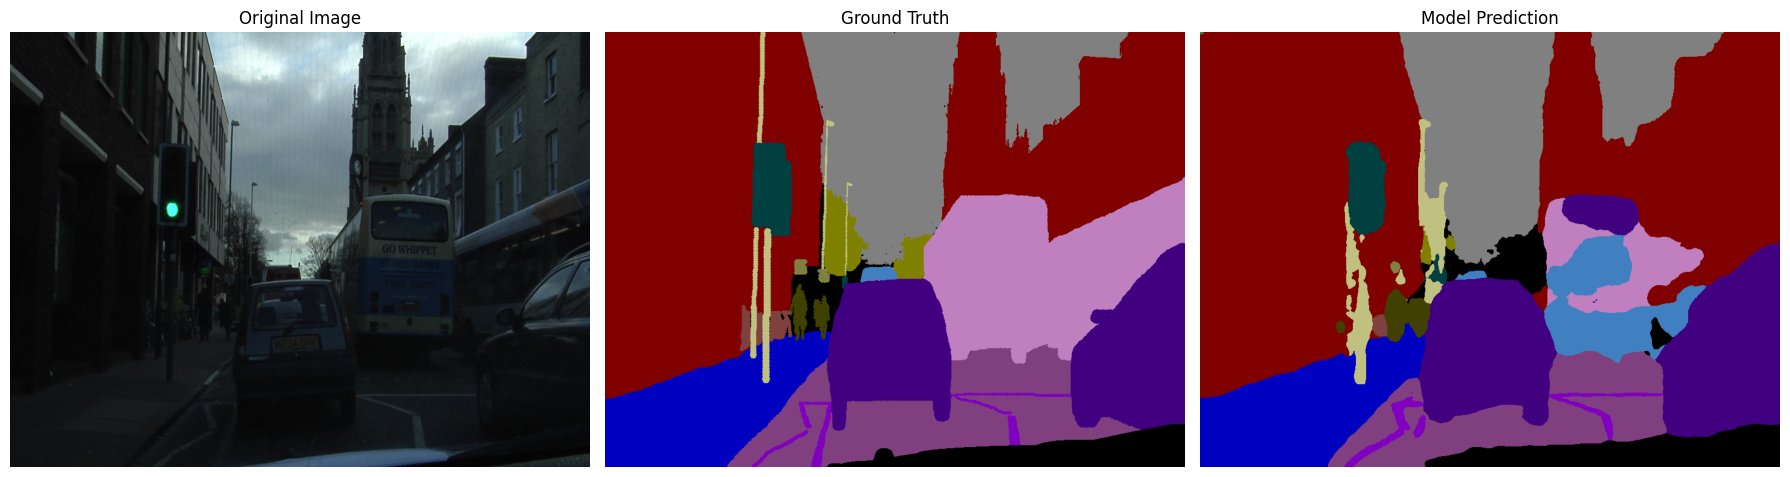

In [3]:
import glob
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Find the best model checkpoint
checkpoint_dir = "/home/thatkar/projects/def-saadi/thatkar/CamVid/checkpoints/"
# best_model_path = glob.glob(os.path.join(checkpoint_dir, 'best_model_loss_*.pth'))[0]
best_model_path = "/home/thatkar/projects/def-saadi/thatkar/CamVid/checkpoints/best_model_loss_b4_0.6576.pth"
print(f"Loading checkpoint from: {best_model_path}")

TEST_IMAGE_PATH = "/home/thatkar/projects/def-saadi/thatkar/CamVid/test/0001TP_006690.png"
# TEST_IMAGE_PATH = "/home/thatkar/projects/def-saadi/thatkar/CamVid/test/0016E5_04530.png"


CLASS_DICT_PATH = "/home/thatkar/projects/def-saadi/thatkar/CamVid/class_dict.csv"

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load class definitions
class_df = pd.read_csv(CLASS_DICT_PATH)

# Initialize feature extractor - Change B5 to B4
feature_extractor = SegformerImageProcessor.from_pretrained(
    "nvidia/mit-b4",    # Changed from mit-b5
    do_reduce_labels=True,
    do_rescale=False,
    size={"height": 640, "width": 640}
)

# Initialize model - Change B5 to B4
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b4",    # Changed from mit-b5
    num_labels=len(class_df),
    ignore_mismatched_sizes=True
).to(device)

# Load checkpoint
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# Get label path
LABEL_PATH = TEST_IMAGE_PATH.replace('/test/', '/test_labels/').replace('.png', '_L.png')

def visualize_prediction(model, image_path, label_path, feature_extractor, class_df, device):
    # Read images
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    label = cv2.imread(label_path)

    orig_h, orig_w = image.shape[:2]

    test_transform = A.Compose([
        A.Resize(height=640, width=640),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    transformed = test_transform(image=image)
    image_tensor = transformed['image'].unsqueeze(0)

    model.eval()
    with torch.no_grad():
        outputs = model(pixel_values=image_tensor.to(device))
        logits = outputs.logits
        upsampled_logits = nn.functional.interpolate(
            logits,
            size=(orig_h, orig_w),
            mode="bilinear",
            align_corners=False
        )
        predicted = upsampled_logits.argmax(dim=1).squeeze().cpu().numpy()

    # Create visualization masks
    pred_mask = np.zeros_like(image)
    truth_mask = np.zeros_like(image)

    for idx, row in class_df.iterrows():
        class_color = np.array([row['r'], row['g'], row['b']])
        pred_mask[predicted == idx] = class_color

        bgr_color = (int(row['b']), int(row['g']), int(row['r']))
        truth_pixels = np.all(label == bgr_color, axis=2)
        truth_mask[truth_pixels] = class_color

    # Plot results
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(truth_mask)
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')

    axes[2].imshow(pred_mask)
    axes[2].set_title('Model Prediction')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Run visualization
visualize_prediction(model, TEST_IMAGE_PATH, LABEL_PATH, feature_extractor, class_df, device)